In [8]:
# For parsing and data manipulation
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import os

# For plotting
import matplotlib.pyplot as plt

In [3]:
def parse_xml_alignment(file_path, detector_type, name=None):
    # Extract the filename from the file path
    filename = os.path.basename(file_path)
    
    # Use provided name or default to filename
    entry_name = name if name else filename
    
    tree = ET.parse(file_path)
    root = tree.getroot()
    
    data = []
    
    for operation in root.findall('operation'):
        for child in operation:
            if child.tag.startswith(detector_type):
                detector = child.tag
                attributes = child.attrib
                
                setposition = operation.find('setposition')
                setape = operation.find('setape')
                
                entry = {
                    'type': detector,
                    'wheel': np.nan, 'station': np.nan, 'sector': np.nan,
                    'superlayer': np.nan, 'endcap': np.nan, 'ring': np.nan, 
                    'chamber': np.nan, 'layer': np.nan,
                    'x': float(setposition.attrib['x']),
                    'y': float(setposition.attrib['y']),
                    'z': float(setposition.attrib['z']),
                    'phix': float(setposition.attrib['phix']),
                    'phiy': float(setposition.attrib['phiy']),
                    'phiz': float(setposition.attrib['phiz']),
                    'xx': float(setape.attrib['xx']),
                    'xy': float(setape.attrib['xy']),
                    'xz': float(setape.attrib['xz']),
                    'xa': float(setape.attrib['xa']),
                    'xb': float(setape.attrib['xb']),
                    'xc': float(setape.attrib['xc']),
                    'yy': float(setape.attrib['yy']),
                    'yz': float(setape.attrib['yz']),
                    'ya': float(setape.attrib['ya']),
                    'yb': float(setape.attrib['yb']),
                    'yc': float(setape.attrib['yc']),
                    'zz': float(setape.attrib['zz']),
                    'za': float(setape.attrib['za']),
                    'zb': float(setape.attrib['zb']),
                    'zc': float(setape.attrib['zc']),
                    'aa': float(setape.attrib['aa']),
                    'ab': float(setape.attrib['ab']),
                    'ac': float(setape.attrib['ac']),
                    'bb': float(setape.attrib['bb']),
                    'bc': float(setape.attrib['bc']),
                    'cc': float(setape.attrib['cc']),
                    'name': entry_name  # Use the provided name or filename
                }
                
                for k, v in attributes.items():
                    if v.lstrip('-').replace('.', '', 1).isdigit():
                        entry[k] = int(v) if v.lstrip('-').isdigit() else float(v)
                    else:
                        entry[k] = np.nan
                
                data.append(entry)
    
    df = pd.DataFrame(data)
    
    # Remove columns that contain only NaNs
    df.dropna(axis=1, how='all', inplace=True)
    
    # Convert detector coordinate columns to integers where applicable
    int_columns = ['wheel', 'station', 'sector', 'superlayer', 'endcap', 'ring', 'chamber', 'layer']
    for col in int_columns:
        if col in df.columns:
            df[col] = df[col].astype(pd.Int64Dtype())
    
    return df

In [36]:
df = parse_xml_alignment("data/Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03.xml", "CSCChamber")
# df2 = parse_xml_alignment("data/Run3 IOV 352319 data.xml", "CSCChamber")
# CSC_list = [df, df2]
# df_DT = parse_xml_alignment("data/Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03.xml", "DTChamber")
# df_DT_SuperLayer = parse_xml_alignment("data/Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03.xml", "DTSuperLayer")
# df_DT_Layer = parse_xml_alignment("data/Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03.xml", "DTLayer")
# df_GEM = parse_xml_alignment("data/Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03.xml", "GEMSuperChamber")

TBMA1 = parse_xml_alignment("data/2024-07-22-CSC_2024B_json_01.xml", "CSCChamber")
TBMA2 = parse_xml_alignment("data/2024-07-22-CSC_2024B_json_02.xml", "CSCChamber")
TBMA3 = parse_xml_alignment("data/2024-07-22-CSC_2024B_json_03.xml", "CSCChamber")
TBMA = [TBMA1, TBMA2, TBMA3]
TBMAdf = [TBMA1, TBMA2, TBMA3, df]

CSCLayerTBMA = parse_xml_alignment("data/2024-07-22-CSC_2024B_json_03.xml", "CSCLayer")
CSCLayerAl = parse_xml_alignment("data/Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03.xml", "CSCLayer")
CSCLayer = [CSCLayerTBMA, CSCLayerAl]

In [71]:
def plot_CSC_chambers_alignment(dfs, endcap, station, ring, par, saveplot=False):
    if not isinstance(dfs, list):
        dfs = [dfs]
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors to use for different DataFrames
    plt.figure(figsize=(15, 5))
    
    for i, df in enumerate(dfs):
        df_filtered = df[(df['endcap'] == endcap) & (df['station'] == station) & (df['ring'] == ring) & (df['type'] == 'CSCChamber')]
        filename = df_filtered['name'].unique()[0]
        color = colors[i % len(colors)]  # Cycle through the list of colors
        
        plt.scatter(df_filtered['chamber'], df_filtered[par], c=color, label=filename, alpha=0.5, s=50)

    # Draw vertical lines to separate chambers
    for chamber in df_filtered['chamber'].unique():
        plt.axvline(chamber, color='grey', linestyle='--', linewidth=0.5)
        
    # Set chamber xticks
    plt.xticks(df_filtered['chamber'].unique(), labels=df_filtered['chamber'].unique())

    plt.legend()
    plt.xlabel('CSC Chamber')
    plt.ylabel(par + ' [cm] or [rad]')
    plt.title(f'Parameter {par} for Endcap {endcap}, Station {station}, Ring {ring}')
    
    # Save plot
    if saveplot:
        plt.tight_layout()
        plt.savefig(f'plots/{saveplot}.png')
    
    plt.show()

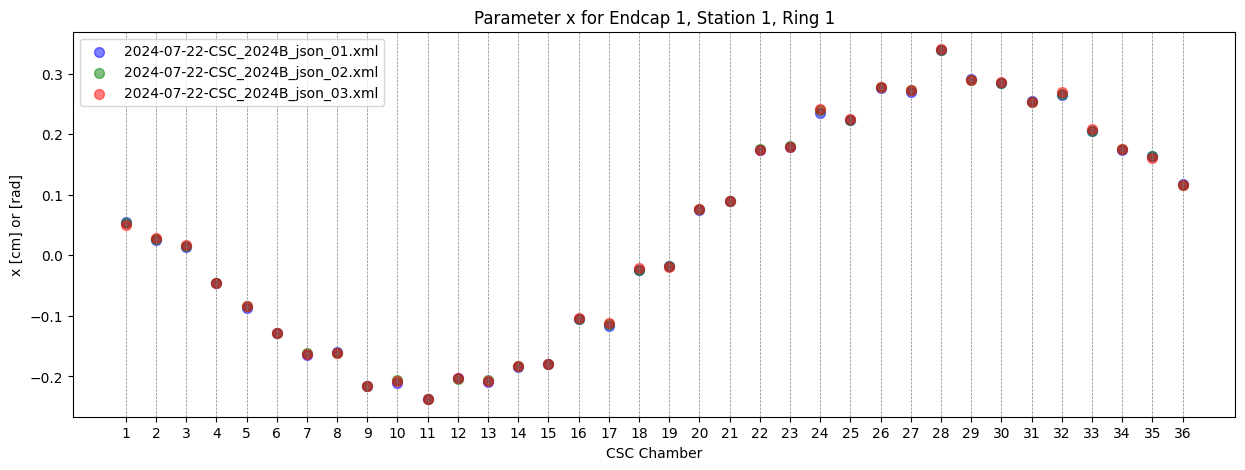

In [89]:
plot_CSC_chambers_alignment(TBMA, 1, 1, 1, "x")

In [193]:
def plot_DT_chamber_alignment(dfs, wheel, station, sector, par, saveplot=False):
    if not isinstance(dfs, list):
        dfs = [dfs]
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors to use for different DataFrames
    plt.figure(figsize=(15, 5))
    
    for i, df in enumerate(dfs):
        df_filtered = df[(df['wheel'] == wheel) & (df['station'] == station) & (df['type'] == 'DTChamber')]
        filename = df_filtered['name'].unique()[0]
        color = colors[i % len(colors)]  # Cycle through the list of colors
        
        plt.scatter(df_filtered['sector'], df_filtered[par], c=color, label=filename)

    # Draw vertical lines to separate superlayers
    for sector in df_filtered['sector'].unique():
        plt.axvline(sector, color='grey', linestyle='--', linewidth=0.5)
        
    # Set superlayer xticks
    plt.xticks(df_filtered['sector'].unique(), labels=df_filtered['sector'].unique())

    plt.legend()
    plt.xlabel('DT Chamber')
    plt.ylabel(par + ' [cm] or [rad]')
    plt.title(f'Parameter {par} for Wheel {wheel}, Station {station}')
    
    # Save plot
    if saveplot:
        plt.tight_layout()
        plt.savefig(f'plots/{saveplot}.png')
    
    plt.show()
    
def plot_DT_layer_alignment(dfs, wheel, station, sector, superlayer, par, saveplot=False):
    if not isinstance(dfs, list):
        dfs = [dfs]
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors to use for different DataFrames
    plt.figure(figsize=(15, 5))


    for i, df in enumerate(dfs):

        df_filtered = df[(df['wheel'] == wheel) & (df['station'] == station) & (df['sector'] == sector) & (df['superlayer'] == superlayer) & (df['type'] == 'DTLayer')]
        filename = df_filtered['name'].unique()[0]
        color = colors[i % len(colors)]  # Cycle through the list of colors
        
        plt.scatter(df_filtered['layer'], df_filtered[par], c=color, label=filename)

    # Draw vertical lines to separate layers
    for layer in df_filtered['layer'].unique():
        plt.axvline(layer, color='grey', linestyle='--', linewidth=0.5)
        
    # Set layer xticks
    plt.xticks(df_filtered['layer'].unique(), labels=df_filtered['layer'].unique())

    plt.legend()
    plt.xlabel('DT Layer')
    plt.ylabel(par + ' [cm] or [rad]')
    plt.title(f'Parameter {par} for Wheel {wheel}, Station {station}, Sector {sector}, Superlayer {superlayer}')
    
    # Save plot
    if saveplot:
        plt.tight_layout()
        plt.savefig(f'plots/{saveplot}.png')
    plt.show()


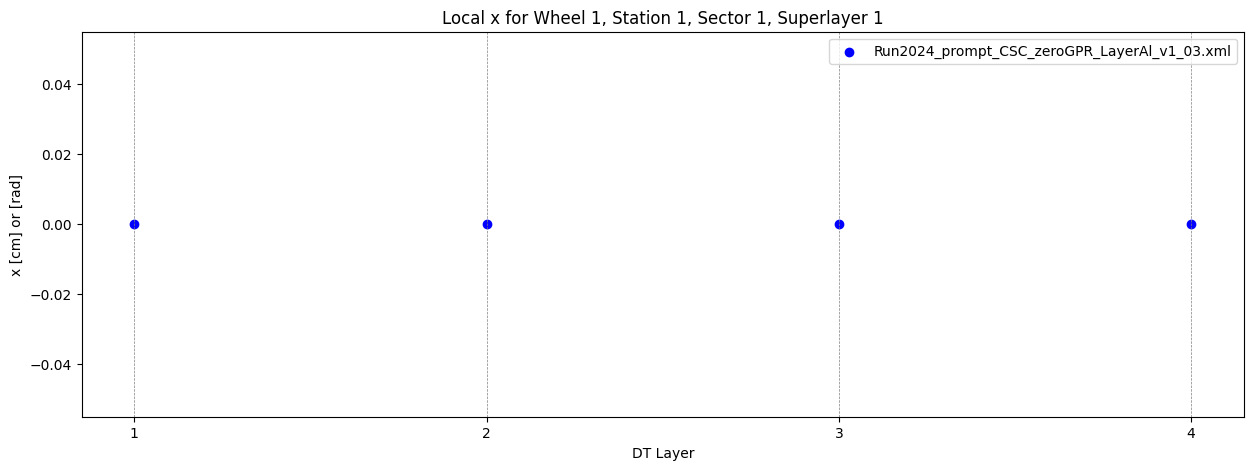

In [153]:
plot_DT_layer_alignment(df_DT_Layer, 1, 1, 1, 1, "x")

In [194]:
def plot_DT_superlayer_alignment(dfs, wheel, station, sector, par, saveplot=False):
    if not isinstance(dfs, list):
        dfs = [dfs] 
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors to use for different DataFrames
    plt.figure(figsize=(15, 5))
    
    for i, df in enumerate(dfs):
        df_filtered = df[(df['wheel'] == wheel) & (df['station'] == station) & (df['sector'] == sector) & (df['type'] == 'DTSuperLayer')]
        filename = df_filtered['name'].unique()[0]
        color = colors[i % len(colors)]
        plt.scatter(df_filtered['superlayer'], df_filtered[par], c=color, label=filename)
        
    # Draw vertical lines to separate superlayers
    for superlayer in df_filtered['superlayer'].unique():
        plt.axvline(superlayer, color='grey', linestyle='--', linewidth=0.5)
        
    # Set superlayer xticks
    plt.xticks(df_filtered['superlayer'].unique(), labels=df_filtered['superlayer'].unique())
    
    plt.legend()
    plt.xlabel('DT SuperLayer')
    plt.ylabel(par + ' [cm] or [rad]')
    plt.title(f'Parameter {par} for Wheel {wheel}, Station {station}, Sector {sector}')
    
    # Save plot
    if saveplot:
        plt.tight_layout()
        plt.savefig(f'plots/{saveplot}.png')
        
    plt.show()

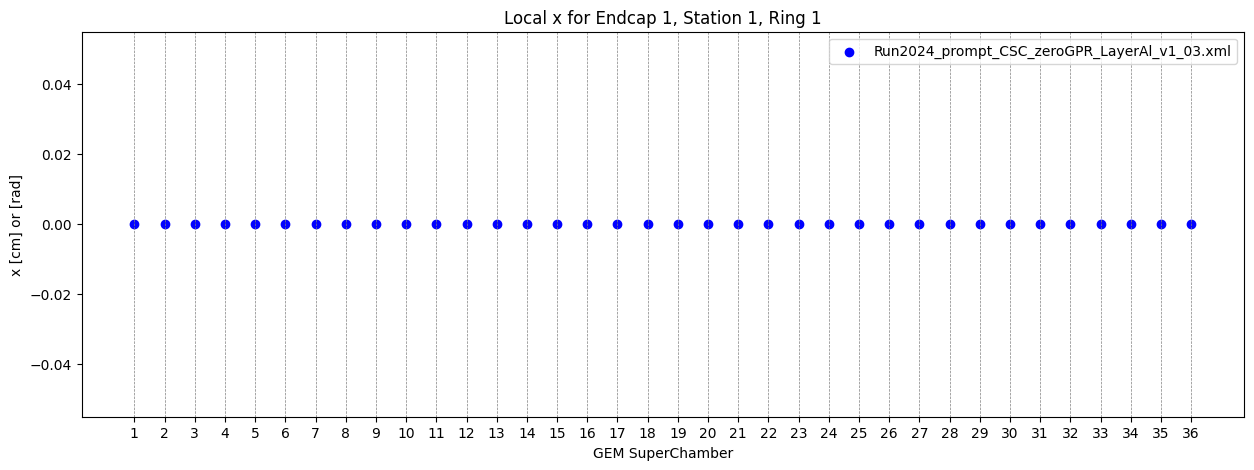

In [195]:
def plot_GEM_superchamber_alignment(dfs, endcap, station, ring, par, saveplot=False):
    if not isinstance(dfs, list):
        dfs = [dfs]
        
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors to use for different DataFrames
    plt.figure(figsize=(15, 5))
    
    for i, df in enumerate(dfs):
        df_filtered = df[(df['endcap'] == endcap) & (df['station'] == station) & (df['ring'] == ring) & (df['type'] == 'GEMSuperChamber')]
        filename = df['name'].unique()[0]
        color = colors[i % len(colors)]
        plt.scatter(df_filtered['chamber'], df_filtered[par], c=color, label=filename)
        
    # Draw vertical lines to separate superchambers
    for superchamber in df_filtered['chamber'].unique():
        plt.axvline(superchamber, color='grey', linestyle='--', linewidth=0.5)
        
    # Set superchamber xticks
    plt.xticks(df_filtered['chamber'].unique(), labels=df_filtered['chamber'].unique())
    
    plt.legend()
    plt.xlabel('GEM SuperChamber')
    plt.ylabel(par + ' [cm] or [rad]')
    plt.title(f'Parameter {par} for Endcap {endcap}, Station {station}, Ring {ring}')
    
    # Save plot
    if saveplot:
        plt.tight_layout()
        plt.savefig(f'plots/{saveplot}.png')
        
    plt.show()
    
plot_GEM_superchamber_alignment(df_GEM, 1, 1, 1, "x")

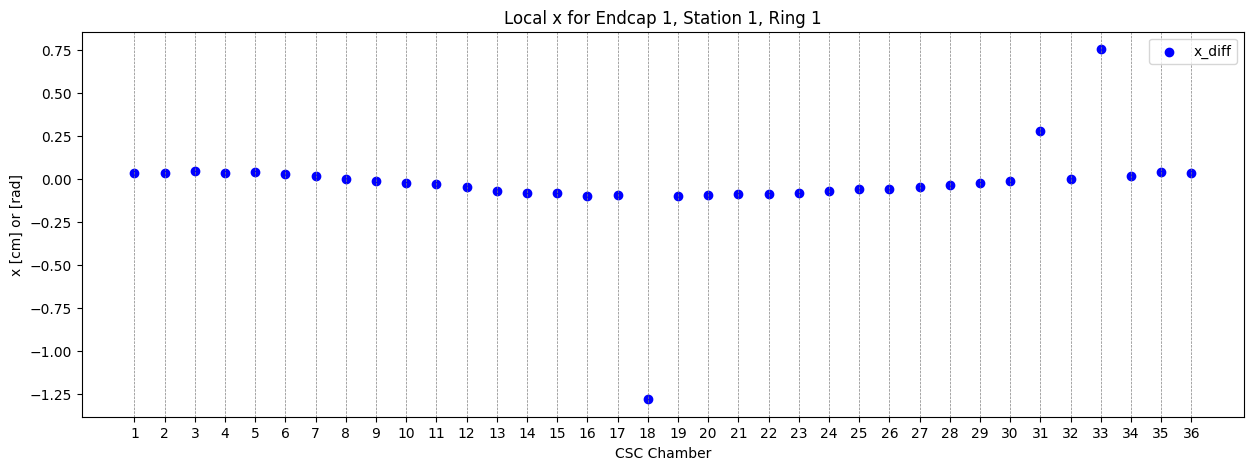

In [6]:
def subtract_alignment(df1, df2, parameter, name):
    # Ensure both dataframes contain the same detector type
    detector_types_1 = set(df1['type'].unique())
    detector_types_2 = set(df2['type'].unique())

    common_detectors = detector_types_1.intersection(detector_types_2)
    if not common_detectors:
        raise ValueError("The two DataFrames do not contain any common detector types.")

    results = []

    for detector_type in common_detectors:
        df1_filtered = df1[df1['type'] == detector_type]
        df2_filtered = df2[df2['type'] == detector_type]

        # Determine common columns for merging, excluding the parameter initially
        common_columns = ['type']
        possible_columns = ['wheel', 'station', 'sector', 'superlayer', 'endcap', 'ring', 'chamber', 'layer']
        for col in possible_columns:
            if col in df1_filtered.columns and col in df2_filtered.columns:
                common_columns.append(col)
        
        # Merge dataframes on common columns, include the parameter separately
        df1_filtered = df1_filtered[common_columns + [parameter]]
        df2_filtered = df2_filtered[common_columns + [parameter]]
        
        common_locations = pd.merge(
            df1_filtered,
            df2_filtered,
            on=common_columns,
            suffixes=('_df1', '_df2')
        )
        
        # Subtract the parameter values and create the new column
        common_locations[parameter] = common_locations[f'{parameter}_df1'] - common_locations[f'{parameter}_df2']
        
        # Add a new column to indicate the difference
        common_locations["name"] = name
        
        # Select relevant columns for the result
        result_columns = common_columns + [parameter, "name"]
        results.append(common_locations[result_columns])

    # Combine results into a single dataframe
    result_df = pd.concat(results, ignore_index=True)
    
    # Remove columns that contain only NaNs
    result_df.dropna(how='all', axis=1, inplace=True)

    return result_df

df_sub = subtract_alignment(df, df2, 'x', 'x_diff')


plot_CSC_chambers_alignment(df_sub, 1, 1, 1, "x")

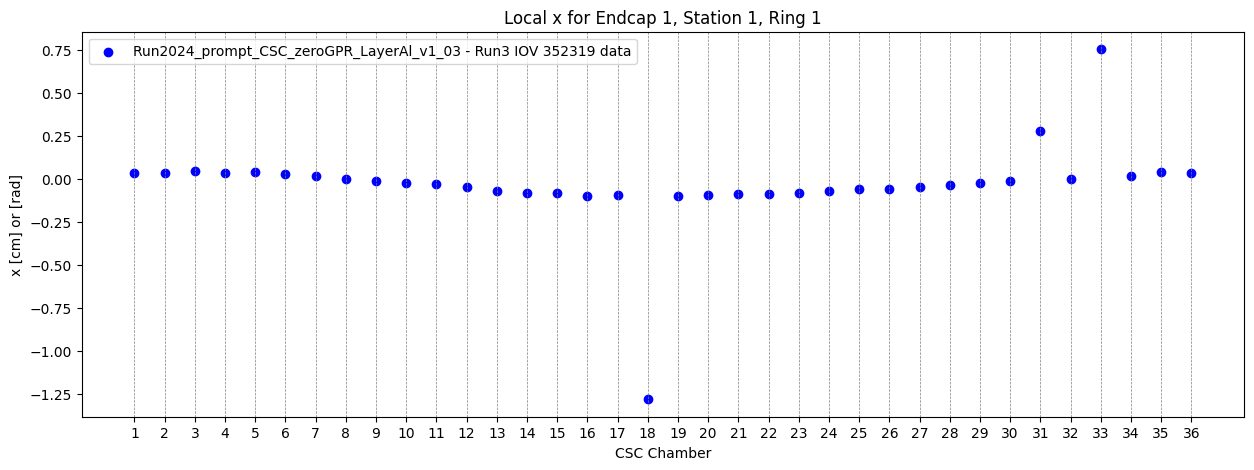

In [7]:
def rename_alignment(df, name):
    df['name'] = name
    return df
df_sub = rename_alignment(df_sub, 'Run2024_prompt_CSC_zeroGPR_LayerAl_v1_03 - Run3 IOV 352319 data')
plot_CSC_chambers_alignment(df_sub, 1, 1, 1, "x")

In [52]:
def plot_CSC_layer_alignment(df_list, endcap, station, ring, chamber, parameter, saveplot=False, df_list_chamber=None):
    if not isinstance(df_list, list):
        df_list = [df_list]
    if df_list_chamber and not isinstance(df_list_chamber, list):
        df_list_chamber = [df_list_chamber]
    if df_list_chamber:
        chamber_line = True
    colors = ['red', 'blue', 'green', 'grey', 'black', 'yellow', 'orange']
    markers = ['o', 's', 'D', '^', 'v', '>', '<']
    
    plt.figure(figsize=(5, 10))
    
    for i, df in enumerate(df_list):
        # Filter dataframe based on the provided endcap, station, ring, and chamber
        df_filtered = df[(df['endcap'] == endcap) & (df['station'] == station) & (df['ring'] == ring) & (df['chamber'] == chamber)]
        
        # Check if the parameter exists in the dataframe
        if parameter not in df_filtered.columns:
            print(f"The parameter '{parameter}' does not exist in the dataframe corresponding to the XML file '{df['name'].iloc[0]}'.")
            continue
        
        # Sort the dataframe by 'layer'
        df_filtered['layer'] = df_filtered['layer'].astype(int)
        df_filtered = df_filtered.sort_values(by='layer')

        # Scatter plot the data
        plt.scatter(df_filtered['layer'], df_filtered[parameter] * 10000, label=df['name'].iloc[0], marker=markers[i % len(markers)], color=colors[i % len(colors)], linewidths=3)
    
    # Plot horizontal chamber line if chamber data is provided
    for i, df in enumerate(df_list_chamber):
        if chamber_line and df_list_chamber:
            df_chamber_filtered = df_list_chamber[i][(df_list_chamber[i]['endcap'] == endcap) & (df_list_chamber[i]['station'] == station) & (df_list_chamber[i]['ring'] == ring) & (df_list_chamber[i]['chamber'] == chamber)]
            if not df_chamber_filtered.empty:
                plt.axhline(y=df_chamber_filtered[parameter].values[0] * 10000, color=colors[i % len(colors)], linestyle='--', label = df_list_chamber[i]['name'].iloc[0])
    # Add vertical lines for each layer
    for k in range(1, 7):
        plt.axvline(x=k, color="grey", linestyle='dotted', linewidth=0.5)
    
    # Add labels and title
    plt.xlabel('Layer Number')
    plt.ylabel(f'{parameter} [µm]')
    plt.title(f'Plot of {parameter} by layer number for endcap {endcap}, station {station}, ring {ring}, and chamber {chamber}')
    
    # Add a legend
    plt.legend()

    # Save the plot if required
    if saveplot:
        plt.tight_layout()
        plt.savefig(f'plots/{saveplot}.png')
    
    # Show the plot
    plt.show()

/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_37475/3555491784.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['layer'] = df_filtered['layer'].astype(int)
/var/folders/nw/8dk2cczn3fdbjmqybvvdjykc0000gn/T/ipykernel_37475/3555491784.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['layer'] = df_filtered['layer'].astype(int)


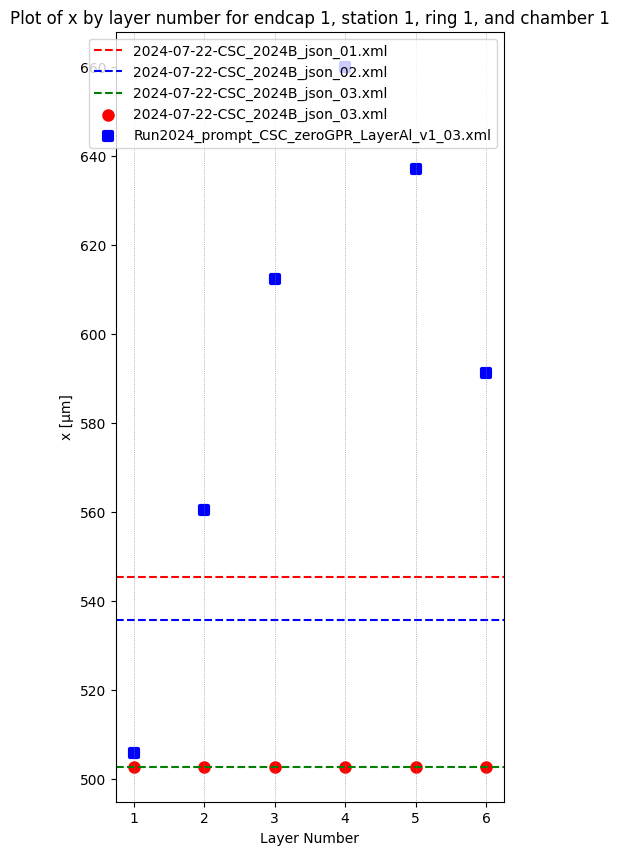

In [53]:
plot_data_layer(CSCLayer, 1, 1, 1, 1, 'x', df_list_chamber=TBMA)